# Бизнес-аналитик - тестовое задание 

## Задание 

Требуется провести анализ изменения цены лечения в 2022 году относительно 2021 года в медицинской клинике и определить ключевые драйверы изменения цены лечения.

**Описание данные:**

- record_id- уникальный идентификатор строки данных
- service_date - дата оказания медицинской услуги
- service_name - наименование медицинской услуги
- service_number - количество услуг
- service_amount - сумма выплат (стоимость оказанных услуг в рублях)
- insured - уникальный идентификатор пациента
- sex_id - пол пациента
- age_for_service_date - возраст пациента

## 1 Откроем файл с данными и изучим общую информацию

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta
import scipy.stats as st
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим исходные данные 
data = pd.read_excel('D:\яп дипломмм/data_test_task_2022.xlsx')

In [3]:
# Изучим исходные данные, выведем первые 10 строчек
data.head(10)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26
5,30268157503,2021-01-24,С-реактивный белок,420,1,490777,2.0,26
6,30268157603,2021-01-24,Взятие крови из периферической вены,158,1,490777,2.0,26
7,30268157703,2021-01-26,Прием первичный,1470,1,490777,2.0,26
8,30268157803,2021-01-26,Магнитотерапия (1 сеанс),1040,1,490777,2.0,26
9,30268157903,2021-01-26,УВЧ-терапия (1 сеанс) (1 поле),1040,1,490777,2.0,26


In [4]:
# Изучим исходную информацию 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


## 2 Изучим и проверим данные

### 2.1 Предобрабокта данных

In [5]:
# Cкорректируем тип данных столбца service_date
data['service_date'] = pd.to_datetime(data['service_date']) 

In [6]:
# Добавим отдельно столбцы с годом и месяцем
data['year'] = pd.to_datetime(data['service_date']).dt.year
data['month'] = pd.to_datetime(data['service_date']).dt.month

In [7]:
# Определение пропусков в столбцах
data.isna().sum().to_frame() 

,0
record_id,0
service_date,0
service_name,0
service_amount,0
service_number,0
insured,0
sex_id,21
age_for_service_date,0
year,0
month,0


В столбце пол пациента имеется 21 пропуск.

In [8]:
# Так как, пропуски составляют 0,02%, удалим их
data = data.dropna()

In [9]:
# Проверим наличие пропусков в столбцах
data.isna().sum().to_frame()

,0
record_id,0
service_date,0
service_name,0
service_amount,0
service_number,0
insured,0
sex_id,0
age_for_service_date,0
year,0
month,0


Пропуски в данных отсутствуют.

In [10]:
# Определение количества дубликатов
print ('Количество дубликатов:', data.duplicated().sum()) 

Количество дубликатов: 0


### 2.2 Изучим исходные данные

In [11]:
# Определим минимальную дату оказания медицинской услуги
min_analysis_date = data['service_date'].min()
print('Минимальная дата оказания медицинской услуги:', min_analysis_date)

Минимальная дата оказания медицинской услуги: 2021-01-03 00:00:00


In [12]:
# Определим максимальную дату оказания медицинской услуги
max_analysis_date = data['service_date'].max()
print('Максимальная дата оказания медицинской услуги:', max_analysis_date)

Максимальная дата оказания медицинской услуги: 2022-08-31 00:00:00


У нас имеются данные с 3 января 2021 года по 31 августа 2022 года.

In [13]:
# Рассмотрим наименования медицинских услуг
data['service_name'].value_counts().to_frame()

,service_name
Прием первичный,6053
Прием повторный,4474
Взятие крови из периферической вены,4214
"Общий анализ крови (лейкоцитарная форм,, СОЭ)",3189
Магнитотерапия (1 сеанс),2838
...,...
Коагуляция при носовом кровотечении р/х ножом,1
Введение турунды с лекарственными формами в нос,1
Андростендион,1
МРТ локтевого сустава,1


Данные содержат информацию о 875 уникальных медицинских услугах, самыми популярными из которых являются: 
- Приём первичный;
- Приём повторный;
- Взятие крови из периферической вены.

In [14]:
# Рассмотрим столбец со стоимостью оказанных услуг
data['service_amount'].describe().to_frame()

,service_amount
count,85348.000000
mean,1166.124783
std,799.064738
min,147.000000
25%,550.000000
50%,1155.000000
75%,1530.000000
max,26999.000000


Минимальная стоимость оказанных услуг составляет 147 руб., максимальная - 26 999 руб. В среднем стоимость оказанных медицинских услуг составляет 1 166 руб. Отрицательных значений нет, данные выглядят корректно.

In [15]:
# Рассмотрим столбец с количеством услуг
data['service_number'].value_counts().sort_index().to_frame()

,service_number
1,83786
2,1373
3,135
4,26
5,10
6,1
7,4
11,1
12,2
13,5


Чаще всего за медицинской услугой обращались 1 раз.

In [16]:
# Определим количество уникальных пациентов
insured_count = data['insured'].nunique()
print('Количество уникальных пациентов:', insured_count)


Количество уникальных пациентов: 4487


In [17]:
# Рассмотрим столбец с полом пациента
# Выведем наименования медицинских услуг, чтобы определить какие из них точно относятся к женщинам
data['service_name'].value_counts().head(15).to_frame()

,service_name
Прием первичный,6053
Прием повторный,4474
Взятие крови из периферической вены,4214
"Общий анализ крови (лейкоцитарная форм,, СОЭ)",3189
Магнитотерапия (1 сеанс),2838
Взятие мазка,1567
Общий анализ мочи,1549
Лазеротерапия (1 сеанс),1313
Интерференционные токи (1 сеанс) (4 поля),1195
Гинекологический мазок,1194


In [18]:
# Определим что означают значения 1.0 и 2.0
data.query('service_name == "Прием гинеколога, повторный"')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,year,month
36074,31680572803,2021-11-22,"Прием гинеколога, повторный",1380,1,743967,2.0,25,2021,11
36097,31680575103,2021-11-26,"Прием гинеколога, повторный",1380,1,716050,2.0,26,2021,11
36112,31680576703,2021-11-12,"Прием гинеколога, повторный",1380,1,716129,2.0,29,2021,11
36131,31680578603,2021-11-22,"Прием гинеколога, повторный",1380,1,512591,2.0,41,2021,11
36238,31680589503,2021-11-05,"Прием гинеколога, повторный",1380,1,544894,2.0,39,2021,11
...,...,...,...,...,...,...,...,...,...,...
85119,33178109503,2022-08-22,"Прием гинеколога, повторный",1450,1,1302647,2.0,33,2022,8
85252,33178132803,2022-08-08,"Прием гинеколога, повторный",1450,1,1154902,2.0,40,2022,8
85255,33178133103,2022-08-10,"Прием гинеколога, повторный",1450,1,1154902,2.0,40,2022,8
85256,33178133203,2022-08-29,"Прием гинеколога, повторный",1450,1,1154902,2.0,40,2022,8


Можно сделать вывод, что значения столбца sex_id 2.0 относится к женщиам, а 1.0 к мужчинам.

In [19]:
# Для более наглядного вывода значений столбца sex_id, заменим категорию пола
data.loc[data['sex_id']==1.0, 'sex_id'] = 'male'
data.loc[data['sex_id']==2.0, 'sex_id'] = 'female'

In [20]:
# Посмотрим на количество пользователей в каждой группе
data['sex_id'].value_counts().to_frame()

,sex_id
female,52804
male,32544


Женщин, обратившихся за медицинскими услугами примерно в 1.5 раза больше, чем мужчин.

In [21]:
# Рассмотрим столбец содержащий возраст пациента
data['age_for_service_date'].describe().to_frame()

,age_for_service_date
count,85348.000000
mean,33.852873
std,12.145506
min,0.000000
25%,27.000000
50%,34.000000
75%,41.000000
max,83.000000


Минимальный возраст пациента, обратившегося в клинику составляет 0 лет, максимальный - 83 года. Среднем возраст пациента составляет 34 года. Отрицательных значений нет, данные выглядят корректно.

**Вывод:**
- Имеются данные с 3 января 2021 года по 31 августа 2022 года;
- Данные содержат информацию о 875 уникальных медицинских услугах, самыми популярными из которых являются: 
  - Приём первичный;
  - Приём повторный;
  - Взятие крови из периферической вены.
- Минимальная стоимость оказанных услуг составляет 147 руб., максимальная - 26 999 руб. В среднем стоимость оказанных медицинских услуг составляет 1 166 руб.;
- Чаще всего за медицинской услугой обращались 1 раз;
- Количество уникальных пациентов: 4487;
- Женщин, обратившихся за медицинскими услугами примерно в 1.5 раза больше, чем мужчин;
- Минимальный возраст пациента, обратившегося в клинику составляет 0 лет, максимальный - 83 года. Среднем возраст пациента составляет 34 года.

## 3 Исследование данных и проверка гипотез

Так как, у нас имеются данные за неполный 2022 год, и учитывая сезонность обращений за медицинскими услугами, сделаем срез по данным 2021 года, чтобы сравнивать данные за одинаковый период времени.

In [22]:
# Добавим столбец с ценой за 1 услугу
data['cost'] = data['service_amount'] / data['service_number']

In [23]:
# Создадим отдельную таблицу с данными за 2021 год
data_2021 = data.query('year == 2021 and month <= 8')

In [24]:
# Создадим отдельную таблицу с данными за 2022 год
data_2022 = data.query('year == 2022')

### 3.1 Анализ изменения цен на услуги

In [25]:
# Группировка данных по услугам и вычисление суммарной выручки за 2021 год
grouped_data_2021 = data_2021.groupby('service_name')['service_amount'].sum().reset_index()

# Сортировка данных по убыванию и выбор топ-10
top_10_services_2021 = grouped_data_2021.sort_values('service_amount', ascending=False).head(10)

# Вывод результата
top_10_services_2021

,service_name,service_amount
398,Прием первичный,6575595
399,Прием повторный,4322396
291,Магнитотерапия (1 сеанс),838240
243,Комплексная мануальная терапия,749700
321,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",688842
476,Сеанс рефлексотерапии,571851
533,Ультразвуковое исследование гинекология трансв...,508200
529,Ультразвуковое исследование брюшной полости,432600
550,Ультразвуковое исследование щитовидной железы ...,393120
191,Интерференционные токи (1 сеанс) (4 поля),380640


In [26]:
# Напишем функцию форматирования валюты для более гибкого отображения
def currency(x, pos):
    'Два аргумента - это значение и позиция отметки.'
    if x >= 1000000:
        return '{:1.1f}M'.format(x*1e-6)
    return '{:1.0f}K'.format(x*1e-3)

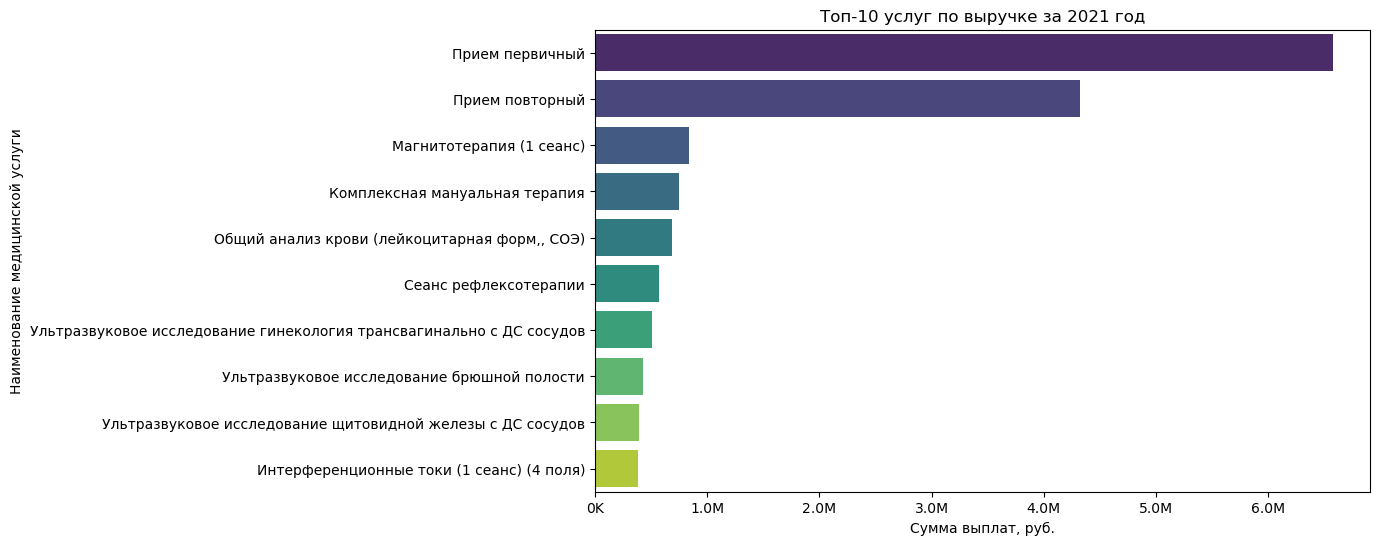

In [27]:
# Отобразим результат графически
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=top_10_services_2021["service_name"], x=top_10_services_2021["service_amount"], ax=ax, palette='viridis')
ax.set(title='Топ-10 услуг по выручке за 2021 год', xlabel='Сумма выплат, руб.', ylabel='Наименование медицинской услуги')
formatter = FuncFormatter(currency)
ax.xaxis.set_major_formatter(formatter)

**Вывод:** Наибольшую выручку в 2021 году принесла медицинская услуга *Прием первичный* - 6 575 595 рублей. Затем идет услуга *Прием повторный* - 4 322 396 рублей, и *Магнитотерапия (1 сеанс)* - 838 240 руб.

In [28]:
# Группировка данных по услугам и вычисление суммарной выручки за 2022 год
grouped_data_2022 = data_2022.groupby('service_name')['service_amount'].sum().reset_index()

# Сортировка данных по убыванию и выбор топ-10
top_10_services_2022 = grouped_data_2022.sort_values('service_amount', ascending=False).head(10)

# Вывод результата
top_10_services_2022

,service_name,service_amount
291,Магнитотерапия (1 сеанс),1588620
447,"Прием трапевта, первичный",1452930
402,"Прием гинеколога, повторный",1343760
325,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",1128850
421,"Прием отоларинголога, первичный",1118820
256,Комплексная мануальная терапия,1096300
414,"Прием невролога, первичный",1072920
609,Ультразвуковое исследование гинекология трансв...,1016540
425,"Прием офтальмолога, первичный",821520
401,"Прием гинеколога, первичный",811220


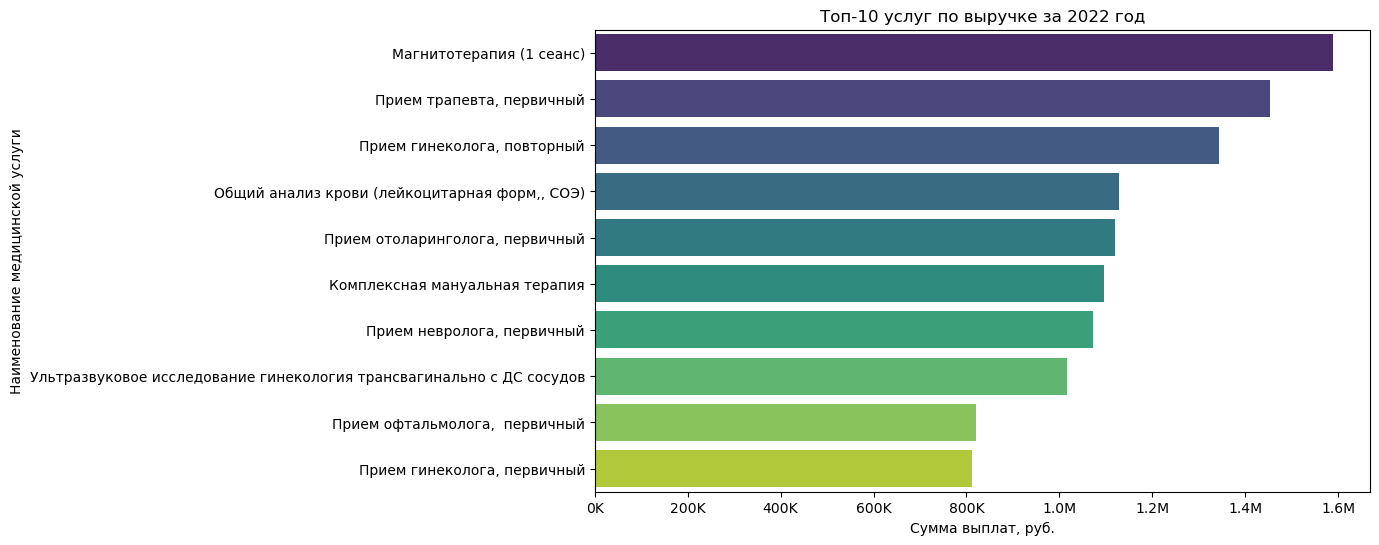

In [29]:
# Отобразим результат графически
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=top_10_services_2022["service_name"], x=top_10_services_2022["service_amount"], ax=ax, palette='viridis')
ax.set(title='Топ-10 услуг по выручке за 2022 год', xlabel='Сумма выплат, руб.', ylabel='Наименование медицинской услуги')
formatter = FuncFormatter(currency)
ax.xaxis.set_major_formatter(formatter)

**Вывод:** Наибольшую выручку в 2022 году принесла медицинская услуга *Магнитотерапия (1 сеанс)* - 1 588 620 рублей. Затем идет услуга *Прием терапевта, первичный* - 1 452 930 рублей, и *Прием гинеколога, повторный* - 1 343 760 руб.

In [30]:
# Посчитаем выручку за 2021 и 2022 года
print('Сумма выручки за 8 месяцев 2021 года:', data_2021['service_amount'].sum())
print('Сумма выручки за 8 месяцев 2022 года:', data_2022['service_amount'].sum())

Сумма выручки за 8 месяцев 2021 года: 29935637
Сумма выручки за 8 месяцев 2022 года: 48986662


In [31]:
# Рассмотрим стоимость услуг в 2021 году
data_2021 = data_2021.rename(columns={'cost':'cost_2021'})
data_2021
data_service_amount_2021 = data_2021[['service_name','cost_2021']].reset_index(drop=True)
data_service_amount_2021

,service_name,cost_2021
0,Прием первичный,1470.0
1,"Взятие материала на посев, цитологическое иссл...",284.0
2,"Посев отдел, дыхательных путей - слизистая зев...",1134.0
3,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693.0
4,Ревматоидный фактор,420.0
...,...,...
26710,Прием повторный,1313.0
26711,Прием повторный,1313.0
26712,Железо сывороточное,287.0
26713,ОЖСС (общая железосвязывающая способность),242.0


In [32]:
# Рассмотрим стоимость услуг в 2022 году
data_2022 = data_2022.rename(columns={'cost':'cost_2022'})
data_service_amount_2022 = data_2022[['service_name','cost_2022']].reset_index(drop=True)
data_service_amount_2022

,service_name,cost_2022
0,Магнитотерапия (1 сеанс),1090.0
1,СМТ-форез (1 сеанс) (2 поля),950.0
2,"Прием невролога, повторный",1380.0
3,Магнитотерапия (1 сеанс),1090.0
4,"Прием физиотерапевта, повторный",1380.0
...,...,...
40972,Общий анализ мочи,495.0
40973,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",800.0
40974,АЧТВ (активированное частичное тромбопластинов...,300.0
40975,Протромбин (МНО),410.0


In [33]:
# Объединим таблицы стоимости услуг по годам
data_2021_2022 = data_service_amount_2021.merge(data_service_amount_2022, on='service_name')
data_2021_2022 = data_2021_2022.drop_duplicates().reset_index(drop=True)
data_2021_2022.head()

,service_name,cost_2021,cost_2022
0,"Взятие материала на посев, цитологическое иссл...",284.0,300.0
1,"Взятие материала на посев, цитологическое иссл...",284.0,330.0
2,"Посев отдел, дыхательных путей - слизистая зев...",1134.0,1190.0
3,"Посев отдел, дыхательных путей - слизистая зев...",1134.0,1200.0
4,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693.0,730.0


In [34]:
# Составим таблицу средней стоимости услуг за 2021 и 2022 года
cost_2021_2022 = data_2021_2022.groupby('service_name').agg({'cost_2021':'mean', 'cost_2022':'mean'}).reset_index()
cost_2021_2022

,service_name,cost_2021,cost_2022
0,"(Б1 (11))Аллергопанель IgE шерсть кошки, шерст...",1449.0,1520.0
1,25-OH витамин D (25-гидроксихолекальциферол),3255.0,3420.0
2,CMV (цитомегаловирус) (Кровь),378.0,400.0
3,CMV (цитомегаловирус) (Слюна),378.0,400.0
4,CMV (цитомегаловирус) (Соскоб),378.0,400.0
...,...,...,...
434,Эпителий собаки,1155.0,1210.0
435,Эстрадиол,630.0,680.0
436,Эхокардиография с допплеровским анализом,3465.0,3820.0
437,альфа-амилаза,287.0,315.0


In [35]:
# Добавим в таблицу столбец с % изменения средней стоимости
cost_2021_2022['percent'] = round((cost_2021_2022['cost_2022'] - cost_2021_2022['cost_2021']) /
              cost_2021_2022['cost_2021'] * 100, 2)

cost_2021_2022

,service_name,cost_2021,cost_2022,percent
0,"(Б1 (11))Аллергопанель IgE шерсть кошки, шерст...",1449.0,1520.0,4.90
1,25-OH витамин D (25-гидроксихолекальциферол),3255.0,3420.0,5.07
2,CMV (цитомегаловирус) (Кровь),378.0,400.0,5.82
3,CMV (цитомегаловирус) (Слюна),378.0,400.0,5.82
4,CMV (цитомегаловирус) (Соскоб),378.0,400.0,5.82
...,...,...,...,...
434,Эпителий собаки,1155.0,1210.0,4.76
435,Эстрадиол,630.0,680.0,7.94
436,Эхокардиография с допплеровским анализом,3465.0,3820.0,10.25
437,альфа-амилаза,287.0,315.0,9.76


In [36]:
# Выведем список характерных статистических показателей
cost_2021_2022['percent'].describe().round(2)

count    439.00
mean       7.57
std        4.19
min      -25.83
25%        5.09
50%        6.73
75%       10.03
max       60.17
Name: percent, dtype: float64

В среднем цены на услуги в 2022 году выросли на **7,6%**.

In [37]:
# Наиболее подорожавшие услуги
cost_2021_2022.query('percent >= 8').sort_values('percent', ascending=False).head()

,service_name,cost_2021,cost_2022,percent
230,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693.0,1110.000000,60.17
85,Взятие мазка,312.5,382.000000,22.24
124,Дуплексное сканирование вен нижних конечностей,2625.0,3166.666667,20.63
83,Введение лекарственных препаратов в наружный с...,263.0,308.000000,17.11
139,Интерпретация результатов Диаскинтеста,1103.0,1280.000000,16.05


Больше всего в 2022 году подорожала медицинская услуга *Общий анализ крови (лейкоцитарная форм,, СОЭ)* - на 60%, затем идет услуга *Взятие мазка* - 22% и Дуплексное сканирование вен нижних конечностей - 21%.

In [38]:
# Не подорожавшие услуги
cost_2021_2022.query('percent <= 0').sort_values('percent')

,service_name,cost_2021,cost_2022,percent
149,Исследование мокроты,809.0,600.000000,-25.83
332,Рентгенография шейного отдела позвоночника (2 ...,1765.0,1605.000000,-9.07
386,Ультразвуковое исследование гинекология абдоми...,1890.0,1806.666667,-4.41


В 2022 году больше всего подешевела медицинская услуга *Исследование мокроты* - на 26%, затем идет уменьшение стоимости услуги *Рентгенография шейного отдела позвоночника* - 9% и *Ультразвуковое исследование гинекология* - 4%.

In [39]:
# Рассмотрим сколько новых услуг появилось в 2022 году

# Создание множества услуг за 2021 год
services_2021 = set(data_2021['service_name'])
# Создание множества услуг за 2022 год
services_2022 = set(data_2022['service_name'])

# Подсчет количества новых услуг в 2022 году
new_services_count = len(services_2022 - services_2021)

# Вывод результата
print("Количество новых услуг в 2022 году:", new_services_count)

Количество новых услуг в 2022 году: 240


In [40]:
# Нахождение новых услуг в 2022 году (список большой, поэтому закомментирую код)
# new_services = services_2022 - services_2021

# Вывод списка новых услуг
# print("Список новых услуг в 2022 году:")
# for service in new_services:
   # print(service)

**Сформулируем гипотезы:**

- Нулевая гипотеза: средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги.
- Альтернативная гипотеза: средняя стоимость обслуживания пациентов не изменилась из-за изменения цен на услуги.

Проверка гипотезы: проведем t-тест для двух независимых выборок. Выборки по размеру разные, поэтому параметр equal_var - False. Уровень статистической значимости зададим 5%.

In [41]:
alpha = 0.05  # критический уровень статистической значимости

# Проведение t-теста 
results = st.ttest_ind(data_2021['service_amount'], data_2022['service_amount'], equal_var=False)

# Вывод результатов
print('p-значение:', results.pvalue)

# Оценка статистической значимости
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение: 2.072947672750582e-32
Отвергаем нулевую гипотезу: разница статистически значима


p-value = 2.072947672750582e-32 меньше 0.05. Значит, нулевую гипотезу о том, что средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги, ***отвергаем***.

**Выводы:** 

- Наибольшую выручку в 2021 году принесла медицинская услуга *Прием первичный* - 6 575 595 рублей. Затем идет услуга *Прием повторный* - 4 322 396 рублей, и *Магнитотерапия (1 сеанс)* - 838 240 руб.;

- Наибольшую выручку в 2022 году принесла медицинская услуга *Магнитотерапия (1 сеанс)* - 1 588 620 рублей. Затем идет услуга *Прием терапевта, первичный* - 1 452 930 рублей, и *Прием гинеколога, повторный* - 1 343 760 руб;

- Сумма выручки за 8 месяцев 2021 года составила - 29 935 637 руб., а за аналогичный период 2022 года - 48 986 662 руб.;

- В среднем цены на услуги в 2022 году выросли на **7,6%**;

- Больше всего в 2022 году подорожала медицинская услуга *Общий анализ крови (лейкоцитарная форм,, СОЭ)* - на 60%, затем идет услуга *Взятие мазка* - 22% и Дуплексное сканирование вен нижних конечностей - 21%;

- В 2022 году больше всего подешевела медицинская услуга *Исследование мокроты* - на 26%, затем идет уменьшение стоимости услуги *Рентгенография шейного отдела позвоночника* - 9% и *Ультразвуковое исследование гинекология* - 4%;

- Количество новых услуг, добавленных в 2022 году составило **240 штук**.

### 3.2 Анализ изменения гендерной структуры обслуживаемых пациентов

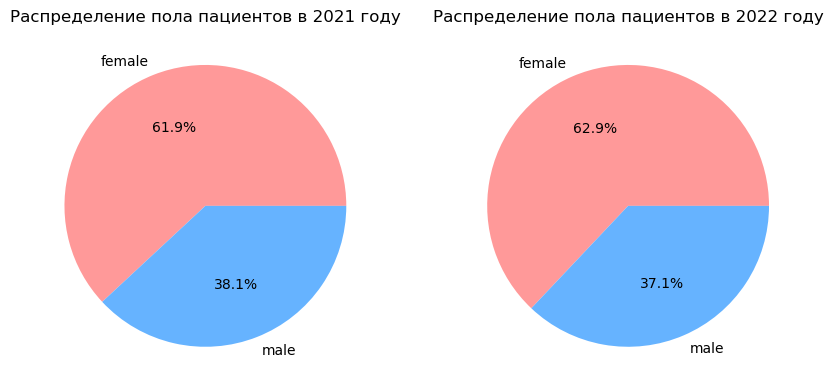

In [42]:
# Группируем данные по полу в 2021 году
gender_counts_2021 = data_2021['sex_id'].value_counts()

# Группируем данные по полу в 2022 году
gender_counts_2022 = data_2022['sex_id'].value_counts()

# Создаем круговую диаграмму
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Палитра цветов
colors = ['#ff9999', '#66b3ff']

# График для 2021 года
ax1.pie(gender_counts_2021, labels=gender_counts_2021.index, autopct='%1.1f%%', colors=colors)
ax1.set_title('Распределение пола пациентов в 2021 году')

# График для 2022 года
ax2.pie(gender_counts_2022, labels=gender_counts_2022.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Распределение пола пациентов в 2022 году')

plt.show()

In [43]:
# Создаем таблицу
table_data = pd.DataFrame({'2021': gender_counts_2021, '2022': gender_counts_2022})
table_data

,2021,2022
female,16544,25795
male,10171,15182


Доли мужчин и женщин от общего количества пациентов отличаются на 1%. В 2022 году доля мужчин сократилась, а доля женщин выросла.

**Сформулируем гипотезы:**
- Нулевая гипотеза: средняя стоимость обслуживания пациентов изменилась из-за изменения гендерной структуры обслуживаемых пациентов.
- Альтернативная гипотеза: средняя стоимость обслуживания пациентов не изменилась из-за изменения гендерной структуры обслуживаемых пациентов.

**Вывод:** Гендерная структура за аналогичный период 2021 и 2022 годов очень похожа, следовательно, отвергаем нулевую гипотезу в пользу альтернативной.

### 3.3 Анализ изменения возрастной структуры обслуживаемых пациентов

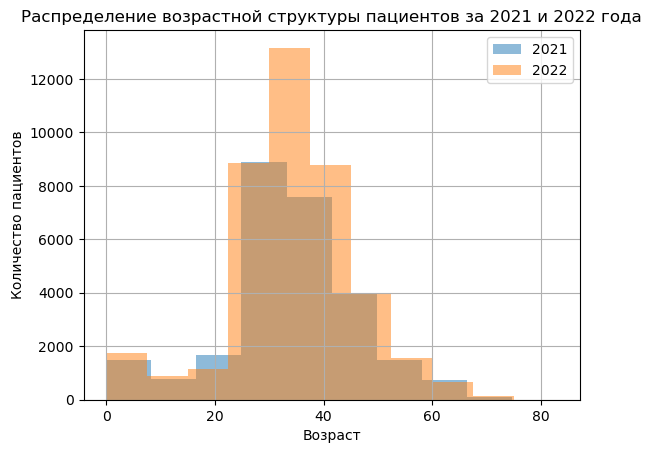

In [44]:
# Построение гистограммы для 2021 года
plt.hist(data_2021['age_for_service_date'], bins=10, alpha=0.5, label='2021')
# Построение гистограммы для 2022 года
plt.hist(data_2022['age_for_service_date'], bins=10, alpha=0.5, label='2022')

# Настройка осей и заголовка
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.title('Распределение возрастной структуры пациентов за 2021 и 2022 года')

# Добавление легенды
plt.legend()

# Добавление сетки
plt.grid(True)

# Отображение графика
plt.show()

In [45]:
# выведем список характерных статистических показателей 
print('2021 год')
print(data_2021['age_for_service_date'].describe().round())
print()
print('2022 год')
print(data_2022['age_for_service_date'].describe().round())

2021 год
count    26715.0
mean        34.0
std         13.0
min          0.0
25%         28.0
50%         34.0
75%         41.0
max         83.0
Name: age_for_service_date, dtype: float64

2022 год
count    40977.0
mean        34.0
std         12.0
min          0.0
25%         27.0
50%         34.0
75%         41.0
max         75.0
Name: age_for_service_date, dtype: float64


**Вывод:** Распределение по возрасту идентично. В 2022 году число обращений увеличилось в 1.5 раза.

**Сформулируем гипотезы:**
- Нулевая гипотеза: средняя стоимость обслуживания пациентов изменилась из-за изменения возрастной структуры пациентов.

- Альтернативная гипотеза: средняя стоимость обслуживания пациентов не изменилась из-за изменения возрастной структуры пациентов.

In [46]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(data_2021['age_for_service_date'], data_2022['age_for_service_date'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение: 3.63892930600857e-05
Отвергаем нулевую гипотезу: разница статистически значима


p-value = 3.63892930600857e-05 меньше 0.05. Значит, нулевую гипотезу о том, что средняя стоимость обслуживания пациентов изменилась из-за изменения возрастной структуры пациентов, ***отвергаем***.

### 4 Общий вывод

Прежде чем исследовать данные была выполнена проверка на их корректность. Данные за 2022 год оказались неполными, следовательно по данным 2021 года был сделан срез, чтобы сравнивать данные за одинаковый период времени.

Согласно анализу:

- Сумма выручки за 8 месяцев 2021 года составила - 29 935 637 руб., а за аналогичный период 2022 года - 48 986 662 руб.;

- В среднем цены на услуги в 2022 году выросли на 7,6%;

- Количество новых услуг, добавленных в 2022 году составило 240 штук;

- Доли мужчин и женщин от общего количества пациентов отличаются на 1%. В 2022 году доля мужчин сократилась, а доля женщин выросла;

- Распределение по возрасту оказалось идентично. В 2022 году число обращений увеличилось в 1.5 раза.

Таким образом, можно предположить, что ключевым драйвером для изменения стоимости лечения стало увеличение средней цены на 7,6% на услуги в 2022 году.